# How to Review Tool Calls (OpenAI Version)

!!! tip "Prerequisites"

    This guide assumes familiarity with the following concepts:

    * [Tool calling](https://python.langchain.com/docs/concepts/tool_calling/)
    * [Human-in-the-loop](../../../concepts/human_in_the_loop)
    * [LangGraph Glossary](../../../concepts/low_level)      

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](../../../concepts/agentic_concepts). A common pattern is to add some human in the loop step after certain tool calls. These tool calls often lead to either a function call or saving of some information. Examples include:

- A tool call to execute SQL, which will then be run by the tool
- A tool call to generate a summary, which will then be saved to the State of the graph

Note that using tool calls is common **whether actually calling tools or not**.

There are typically a few different interactions you may want to do here:

1. Approve the tool call and continue
2. Modify the tool call manually and then continue
3. Give natural language feedback, and then pass that back to the agent


We can implement these in LangGraph using the [`interrupt()`][langgraph.types.interrupt] function. `interrupt` allows us to stop graph execution to collect input from a user and continue execution with collected input:


```python
def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call
        }
    )
    
    review_action, review_data = human_review
    
    # Approve the tool call and continue
    if review_action == "continue":
        return Command(goto="run_tool")
    
    # Modify the tool call manually and then continue
    elif review_action == "update":
        ...
        updated_msg = get_updated_msg(review_data)
        return Command(goto="run_tool", update={"messages": [updated_message]})

    # Give natural language feedback, and then pass that back to the agent
    elif review_action == "feedback":
        ...
        feedback_msg = get_feedback_msg(review_data)
        return Command(goto="call_llm", update={"messages": [feedback_msg]})

```

## Setup

First we need to install the packages required

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-openai "httpx>=0.24.0,<1.0.0"

Next, we need to set API keys for OpenAI (the LLM we will use in this notebook)

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Simple Usage

Let's set up a very simple graph that facilitates this.
First, we will have an LLM call that decides what action to take.
Then we go to a human node. This node actually doesn't do anything - the idea is that we interrupt before this node and then apply any updates to the state.
After that, we check the state and either route back to the LLM or to the correct tool.

Let's see this in action!

21:02:24 langgraph.checkpoint.redis INFO   Redis client is a standalone client
21:02:24 redisvl.index.index INFO   Index already exists, not overwriting.
21:02:24 redisvl.index.index INFO   Index already exists, not overwriting.
21:02:24 redisvl.index.index INFO   Index already exists, not overwriting.


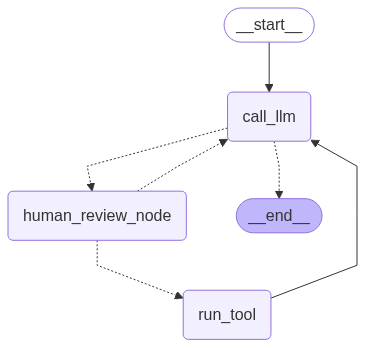

In [3]:
from typing_extensions import Literal
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.redis import RedisSaver
from langgraph.types import Command, interrupt
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from IPython.display import Image, display

# Set up Redis connection
REDIS_URI = "redis://redis:6379"
memory = None
with RedisSaver.from_conn_string(REDIS_URI) as cp:
    cp.setup()
    memory = cp


@tool
def weather_search(city: str):
    """Search for the weather"""
    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"


# Use OpenAI with tool binding
model = ChatOpenAI(model="gpt-4o").bind_tools([weather_search])


class State(MessagesState):
    """Simple state."""


def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]

    # Get the tool call from OpenAI format
    tool_call = last_message.tool_calls[-1] if hasattr(last_message, "tool_calls") and last_message.tool_calls else None

    # this is the value we'll be providing via Command(resume=<human_review>)
    human_review = interrupt(
        {
            "question": "Is this correct?",
            # Surface tool calls for review
            "tool_call": tool_call,
        }
    )

    review_action = human_review["action"]
    review_data = human_review.get("data")

    # if approved, call the tool
    if review_action == "continue":
        return Command(goto="run_tool")

    # update the AI message AND call tools
    elif review_action == "update":
        # Handle OpenAI format
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    # This the update provided by the human
                    "args": review_data,
                }
            ],
            # This is important - this needs to be the same as the message you replacing!
            # Otherwise, it will show up as a separate message
            "id": last_message.id,
        }

        return Command(goto="run_tool", update={"messages": [updated_message]})

    # provide feedback to LLM
    elif review_action == "feedback":
        # NOTE: we're adding feedback message as a ToolMessage
        # to preserve the correct order in the message history
        # (AI messages with tool calls need to be followed by tool call messages)
        tool_message = {
            "role": "tool",
            # This is our natural language feedback
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})


def run_tool(state):
    new_messages = []
    tools = {"weather_search": weather_search}

    # Get tool calls from OpenAI format
    last_message = state["messages"][-1]
    tool_calls = last_message.tool_calls if hasattr(last_message, "tool_calls") else []

    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        if tool_name in tools:
            tool = tools[tool_name]
            result = tool.invoke(tool_call["args"])
            new_messages.append(
                {
                    "role": "tool",
                    "name": tool_call["name"],
                    "content": result,
                    "tool_call_id": tool_call["id"],
                }
            )
    return {"messages": new_messages}


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    last_message = state["messages"][-1]

    # Check for OpenAI tool calls
    has_tool_calls = hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0

    if has_tool_calls:
        return "human_review_node"
    else:
        return END


builder = StateGraph(State)
builder.add_node(call_llm)
builder.add_node(run_tool)
builder.add_node(human_review_node)
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Example with no review

Let's look at an example when no review is required (because no tools are called)

In [4]:
# Input
initial_input = {"messages": [{"role": "user", "content": "hi!"}]}

# Thread
thread = {"configurable": {"thread_id": "openai-1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

21:02:26 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'call_llm': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 44, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C1fZBywasJAKmXpBtFWCG1oaewwQR', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2a5425b7-05bd-4202-b74f-49707804f567-0', usage_metadata={'input_tokens': 44, 'output_tokens': 10, 'total_tokens': 54, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}




If we check the state, we can see that it is finished

## Example of approving tool

Let's now look at what it looks like to approve a tool call

In [5]:
# Input
initial_input = {"messages": [{"role": "user", "content": "what's the weather in sf?"}]}

# Thread
thread = {"configurable": {"thread_id": "openai-2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

21:02:29 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uSsZcpdEt4Dc8X9zTKbdvrk1', 'function': {'arguments': '{"city":"San Francisco"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 49, 'total_tokens': 64, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff25b2783a', 'id': 'chatcmpl-C1fZFcekJpNMlPgJZMD2vQi4b5GIH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4a7549c7-c58f-449b-aba3-01403976766c-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'call_uSsZcpdEt4Dc

If we now check, we can see that it is waiting on human review

In [6]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


To approve the tool call, we can just continue the thread with no edits. To do so, we need to let `human_review_node` know what value to use for the `human_review` variable we defined inside the node. We can provide this value by invoking the graph with a `Command(resume=<human_review>)` input.  Since we're approving the tool call, we'll provide `resume` value of `{"action": "continue"}` to navigate to `run_tool` node:

In [7]:
for event in graph.stream(
        # provide value
        Command(resume={"action": "continue"}),
        thread,
        stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': None}


----
Searching for: San Francisco
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'call_uSsZcpdEt4Dc8X9zTKbdvrk1'}]}}


21:02:33 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'call_llm': {'messages': [AIMessage(content='The weather in San Francisco is sunny!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 74, 'total_tokens': 83, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C1fZJ85HYzmf43GynpaiTmQOEUXmw', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--41accede-5ba9-483e-88cd-8ca10b801465-0', usage_metad

## Edit Tool Call

Let's now say we want to edit the tool call. E.g. change some of the parameters (or even the tool called!) but then execute that tool.

In [8]:
# Input
initial_input = {"messages": [{"role": "user", "content": "what's the weather in sf?"}]}

# Thread
thread = {"configurable": {"thread_id": "openai-3"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

21:02:34 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e6WVBymEECivHxeiR0oo21Sg', 'function': {'arguments': '{"city":"San Francisco"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 49, 'total_tokens': 64, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C1fZJit4HCesODEgYgw9YLhais4zu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b5cff8af-f180-4b33-b677-138ce514501b-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'call_e6WVBymEECiv

In [9]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


To do this, we will use `Command` with a different resume value of `{"action": "update", "data": <tool call args>}`. This will do the following:

* combine existing tool call with user-provided tool call arguments and update the existing AI message with the new tool call
* navigate to `run_tool` node with the updated AI message and continue execution

In [10]:
# Let's now continue executing from here
for event in graph.stream(
        Command(resume={"action": "update", "data": {"city": "San Francisco, USA"}}),
        thread,
        stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': {'messages': [{'role': 'ai', 'content': '', 'tool_calls': [{'id': 'call_e6WVBymEECivHxeiR0oo21Sg', 'name': 'weather_search', 'args': {'city': 'San Francisco, USA'}}], 'id': 'run--b5cff8af-f180-4b33-b677-138ce514501b-0'}]}}


----
Searching for: San Francisco, USA
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'call_e6WVBymEECivHxeiR0oo21Sg'}]}}


21:02:35 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'call_llm': {'messages': [AIMessage(content='The weather in San Francisco is currently sunny!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 76, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o

## Give feedback to a tool call

Sometimes, you may not want to execute a tool call, but you also may not want to ask the user to manually modify the tool call. In that case it may be better to get natural language feedback from the user. You can then insert this feedback as a mock **RESULT** of the tool call.

There are multiple ways to do this:

1. You could add a new message to the state (representing the "result" of a tool call)
2. You could add TWO new messages to the state - one representing an "error" from the tool call, other HumanMessage representing the feedback

Both are similar in that they involve adding messages to the state. The main difference lies in the logic AFTER the `human_review_node` and how it handles different types of messages.

For this example we will just add a single tool call representing the feedback (see `human_review_node` implementation). Let's see this in action!

In [11]:
# Input
initial_input = {"messages": [{"role": "user", "content": "what's the weather in sf?"}]}

# Thread
thread = {"configurable": {"thread_id": "openai-4"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

21:02:36 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jhbfIadeAUhbRZiZUcpJ2J9L', 'function': {'arguments': '{"city":"San Francisco"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 49, 'total_tokens': 64, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C1fZMVok7zk7bDQe5CoCRtyB2S7jY', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4a97863f-9062-4606-a77c-85aeaa8e6230-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'call_jhbfIadeAUhb

In [12]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


To do this, we will use `Command` with a different resume value of `{"action": "feedback", "data": <feedback string>}`. This will do the following:

* create a new tool message that combines existing tool call from LLM with the with user-provided feedback as content
* navigate to `call_llm` node with the updated tool message and continue execution

In [13]:
# Let's now continue executing from here
for event in graph.stream(
        # provide our natural language feedback!
        Command(
            resume={
                "action": "feedback",
                "data": "User requested changes: use <city, country> format for location",
            }
        ),
        thread,
        stream_mode="updates",
):
    print(event)
    print("\n")

{'human_review_node': {'messages': [{'role': 'tool', 'content': 'User requested changes: use <city, country> format for location', 'name': 'weather_search', 'tool_call_id': 'call_jhbfIadeAUhbRZiZUcpJ2J9L'}]}}


21:02:37 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fkJ8ejxWKbS93gh3TED8Wgay', 'function': {'arguments': '{"city":"San Francisco, US"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 85, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff25b2783a', 'id': 'chatcmpl-C1fZMx0GCybunve8iIxQyqXYdGn9l', 'service_

We can see that we now get to another interrupt - because it went back to the model and got an entirely new prediction of what to call. Let's now approve this one and continue.

In [14]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


In [15]:
for event in graph.stream(
        Command(resume={"action": "continue"}), thread, stream_mode="updates"
):
    print(event)
    print("\n")

{'human_review_node': None}


----
Searching for: San Francisco, US
----
{'run_tool': {'messages': [{'role': 'tool', 'name': 'weather_search', 'content': 'Sunny!', 'tool_call_id': 'call_fkJ8ejxWKbS93gh3TED8Wgay'}]}}


21:02:38 httpx INFO   HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'call_llm': {'messages': [AIMessage(content='The weather in San Francisco, US is currently sunny!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 112, 'total_tokens': 124, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C1fZOGLXka23L4tOQ9iuXsaVyCsY9', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--78edff96-6960-45ad-8d4a-3fec46a